### Bandpass and Notch Filtering  
  
A function was added to utils.py that performs both bandpass filtering and notch filtering if notch is set to True. A new feature set will be extracted from 12k sub EEGs that have been scaled and bandpass filtered. Then KNN will be run and the results will be compared with the base model results.  
  
I'll try some different setting for the bandpass filter and then I'll try notch filtering and see how that affects results. The notch filter is set at 60 Hz because the data comes from the US. There are different settings to test with it. Some alternative approaches to handling power line noise can be tried, though.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastparquet, pyarrow
import mne
from mne.decoding import Scaler
from mne_features.univariate import compute_pow_freq_bands
from utils import *

In [2]:
mne.set_log_level('WARNING')

In [3]:
df = pd.read_csv('by_patient.csv')

In [4]:
other_df = activity_df(df, 'Other', 'expert_consensus')
seizure_df = activity_df(df, 'Seizure', 'expert_consensus')
lpd_df = activity_df(df, 'LPD', 'expert_consensus')
gpd_df = activity_df(df, 'GPD', 'expert_consensus')
lrda_df = activity_df(df, 'LRDA', 'expert_consensus')
grda_df = activity_df(df, 'GRDA', 'expert_consensus')

In [5]:
activity_df_list = [other_df, seizure_df, gpd_df, lpd_df, grda_df, lrda_df]

In [6]:
bandpass_df = pd.read_csv('bandpass_df.csv')

In [7]:
#bandpass_df = full_band_df(2000, activity_df_list, 1, 70, notch = False)

In [8]:
bandpass_df.shape

(12000, 95)

In [9]:
y_true = get_yvals(2000)

In [10]:
#bandpass_df.to_csv('bandpass_df.csv', index = None)

In [11]:
X1 = pd.read_csv('bandfeatures_12000.csv')
X2 = bandpass_df

In [12]:
X1 = X1.drop(columns = ['activity']).copy()
y1  = y_true['activity'].copy()
y2 = y_true['activity'].copy()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
skl_scaler = StandardScaler()
X1 = skl_scaler.fit_transform(X1)

skl_scaler2 = StandardScaler()
X2 = skl_scaler2.fit_transform(X2)

In [15]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.1)

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

### Before Bandpass Filtering

In [17]:
knn = KNeighborsClassifier()
knn.fit(X1_train, y1_train)
training_yhat1 = knn.predict(X1_train)
testing_yhat1 = knn.predict(X1_test)
print('Training')
print(classification_report(y1_train, training_yhat1))
print('Testing')
print(classification_report(y1_test, testing_yhat1))

Training
              precision    recall  f1-score   support

         GPD       0.80      0.92      0.86      1784
        GRDA       0.73      0.86      0.79      1795
         LPD       0.74      0.87      0.80      1805
        LRDA       0.79      0.89      0.83      1813
       Other       0.76      0.52      0.62      1789
     Seizure       0.86      0.60      0.71      1814

    accuracy                           0.77     10800
   macro avg       0.78      0.77      0.77     10800
weighted avg       0.78      0.77      0.77     10800

Testing
              precision    recall  f1-score   support

         GPD       0.70      0.86      0.77       216
        GRDA       0.61      0.76      0.68       205
         LPD       0.65      0.81      0.72       195
        LRDA       0.71      0.78      0.74       187
       Other       0.62      0.35      0.45       211
     Seizure       0.67      0.41      0.51       186

    accuracy                           0.66      1200
   mac

### After Bandpass Filtering

In [18]:
knn = KNeighborsClassifier()
knn.fit(X2_train, y2_train)
training_yhat2 = knn.predict(X2_train)
testing_yhat2 = knn.predict(X2_test)
print('Training')
print(classification_report(y2_train, training_yhat2))
print('Testing')
print(classification_report(y2_test, testing_yhat2))

Training
              precision    recall  f1-score   support

         GPD       0.78      0.91      0.84      1776
        GRDA       0.75      0.87      0.81      1789
         LPD       0.75      0.86      0.80      1813
        LRDA       0.83      0.88      0.85      1801
       Other       0.77      0.57      0.66      1807
     Seizure       0.87      0.64      0.74      1814

    accuracy                           0.79     10800
   macro avg       0.79      0.79      0.78     10800
weighted avg       0.79      0.79      0.78     10800

Testing
              precision    recall  f1-score   support

         GPD       0.70      0.84      0.76       224
        GRDA       0.64      0.80      0.71       211
         LPD       0.67      0.81      0.73       187
        LRDA       0.76      0.75      0.76       199
       Other       0.63      0.36      0.46       193
     Seizure       0.74      0.56      0.64       186

    accuracy                           0.69      1200
   mac

### Initial Notes on Results  
  
Bandpass filtering with a frequency band of 1 to 70 Hz improved the KNN testing accuracy by 3%. I'll try some different setting for the bandpass filter. 1 and 70 were the recommendations from Learning EEG.

I'll adjust these individually to see how each affects the outcome relative to the above outcome.  
  
### Highpass Filter 0 Hz

In [28]:
raw = load_preprocess(df, 500, 0.5, None, bandpass = True, notch = False, reref = False)

In [29]:
raw.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,"19 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,EKG
Sampling frequency,200.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


In [19]:
#highpass_alt1 = full_band_df(2000, activity_df_list, 0, 70, notch = False)

In [20]:
#highpass_alt1.to_csv('highpass00.csv', index = None)

In [21]:
highpass_alt1 = pd.read_csv('highpass00.csv')

In [22]:
X = highpass_alt1.copy()
y = y_true['activity'].copy()

In [23]:
scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

### Notes on Results  
  
Testing accuracy dropped 2% by changing the highpass filter back to the default 0 Hz.

In [25]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training')
print(classification_report(y_train, training_yhat))
print('Testing')
print(classification_report(y_test, testing_yhat))

Training
              precision    recall  f1-score   support

         GPD       0.77      0.92      0.84      1793
        GRDA       0.73      0.87      0.79      1793
         LPD       0.74      0.85      0.79      1800
        LRDA       0.82      0.86      0.84      1797
       Other       0.74      0.55      0.63      1801
     Seizure       0.87      0.59      0.70      1816

    accuracy                           0.77     10800
   macro avg       0.78      0.77      0.77     10800
weighted avg       0.78      0.77      0.77     10800

Testing
              precision    recall  f1-score   support

         GPD       0.70      0.86      0.77       207
        GRDA       0.62      0.75      0.68       207
         LPD       0.63      0.80      0.70       200
        LRDA       0.74      0.78      0.76       203
       Other       0.64      0.38      0.48       199
     Seizure       0.74      0.44      0.55       184

    accuracy                           0.67      1200
   mac

### Highpass Filter 0.5 Hz

In [41]:
#highpass_alt2 = full_band_df(2000, activity_df_list, 0.5, 70, notch = False)

In [42]:
#highpass_alt2.to_csv('highpass05.csv', index = None)

In [ ]:
highpass_alt2 = pd.read_csv('highpass05.csv')

In [30]:
X = highpass_alt2.copy()

scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [31]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training')
print(classification_report(y_train, training_yhat))
print('Testing')
print(classification_report(y_test, testing_yhat))

Training
              precision    recall  f1-score   support

         GPD       0.80      0.92      0.86      1794
        GRDA       0.74      0.88      0.81      1819
         LPD       0.77      0.86      0.81      1800
        LRDA       0.82      0.87      0.84      1795
       Other       0.77      0.57      0.66      1808
     Seizure       0.88      0.64      0.74      1784

    accuracy                           0.79     10800
   macro avg       0.80      0.79      0.79     10800
weighted avg       0.80      0.79      0.79     10800

Testing
              precision    recall  f1-score   support

         GPD       0.72      0.87      0.79       206
        GRDA       0.62      0.83      0.71       181
         LPD       0.66      0.74      0.70       200
        LRDA       0.72      0.76      0.74       205
       Other       0.60      0.41      0.48       192
     Seizure       0.75      0.49      0.59       216

    accuracy                           0.68      1200
   mac

### Highpass Filter 1.5 Hz

In [43]:
#highpass_alt3 = full_band_df(2000, activity_df_list, 1.5, 70, notch = False)

In [44]:
#highpass_alt3.to_csv('highpass15.csv', index = None)

In [ ]:
highpass_alt3 = pd.read_csv('highpass15.csv')

In [34]:
X = highpass_alt3.copy()

scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [35]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training')
print(classification_report(y_train, training_yhat))
print('Testing')
print(classification_report(y_test, testing_yhat))

Training
              precision    recall  f1-score   support

         GPD       0.80      0.92      0.86      1794
        GRDA       0.75      0.88      0.81      1819
         LPD       0.76      0.86      0.81      1800
        LRDA       0.82      0.88      0.85      1795
       Other       0.77      0.58      0.66      1808
     Seizure       0.89      0.63      0.74      1784

    accuracy                           0.79     10800
   macro avg       0.80      0.79      0.79     10800
weighted avg       0.80      0.79      0.79     10800

Testing
              precision    recall  f1-score   support

         GPD       0.70      0.89      0.78       206
        GRDA       0.57      0.80      0.66       181
         LPD       0.67      0.71      0.69       200
        LRDA       0.73      0.74      0.74       205
       Other       0.56      0.36      0.44       192
     Seizure       0.76      0.48      0.59       216

    accuracy                           0.66      1200
   mac

### Highpass Filter 2 Hz

In [45]:
#highpass_alt4 = full_band_df(2000, activity_df_list, 2, 70, notch = False)

In [46]:
#highpass_alt4.to_csv('highpass20.csv', index = None)

In [ ]:
highpass_alt4 = pd.read_csv('highpass20.csv')

In [38]:
X = highpass_alt4.copy()

scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [39]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training')
print(classification_report(y_train, training_yhat))
print('Testing')
print(classification_report(y_test, testing_yhat))

Training
              precision    recall  f1-score   support

         GPD       0.80      0.93      0.86      1794
        GRDA       0.74      0.89      0.81      1819
         LPD       0.76      0.87      0.81      1800
        LRDA       0.83      0.88      0.85      1795
       Other       0.78      0.56      0.65      1808
     Seizure       0.88      0.62      0.73      1784

    accuracy                           0.79     10800
   macro avg       0.80      0.79      0.79     10800
weighted avg       0.80      0.79      0.79     10800

Testing
              precision    recall  f1-score   support

         GPD       0.71      0.87      0.78       206
        GRDA       0.64      0.80      0.71       181
         LPD       0.65      0.81      0.72       200
        LRDA       0.77      0.80      0.79       205
       Other       0.64      0.40      0.49       192
     Seizure       0.74      0.49      0.59       216

    accuracy                           0.69      1200
   mac

### Notes on Highpass Filter Results  
  
0.5 and 1.0 had equivalent testing accuracies and 2.0 had a testing accuracy 1% higher than those. This difference isn't substantial and it's best to err on the side of caution when it comes to filtering out data, so I'm likely to go with a highpass filter of 0.5 going forward. I want to test some values between 0.5 and 1 first and then start testing different values for the lowpass filter.

In [50]:
#highpass_alt5 = full_band_df(2000, activity_df_list, 0.6, 70, notch = False)
#highpass_alt5.to_csv('highpass06.csv', index = None)

In [48]:
highpass_alt5 = pd.read_csv('highpass06.csv')

X = highpass_alt5.copy()

scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [49]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (Highpass 0.6 Hz)')
print(classification_report(y_train, training_yhat))
print('Testing (Highpass 0.6 Hz)')
print(classification_report(y_test, testing_yhat))

Training (Highpass 0.6 Hz)
              precision    recall  f1-score   support

         GPD       0.80      0.93      0.86      1794
        GRDA       0.74      0.86      0.80      1819
         LPD       0.74      0.86      0.80      1800
        LRDA       0.82      0.88      0.85      1795
       Other       0.75      0.54      0.62      1808
     Seizure       0.86      0.62      0.72      1784

    accuracy                           0.78     10800
   macro avg       0.79      0.78      0.78     10800
weighted avg       0.79      0.78      0.78     10800

Testing (Highpass 0.6 Hz)
              precision    recall  f1-score   support

         GPD       0.71      0.88      0.79       206
        GRDA       0.63      0.81      0.71       181
         LPD       0.61      0.70      0.65       200
        LRDA       0.72      0.81      0.76       205
       Other       0.53      0.34      0.42       192
     Seizure       0.69      0.39      0.50       216

    accuracy            

In [54]:
#highpass_alt6 = full_band_df(2000, activity_df_list, 0.7, 70, notch = False)
#highpass_alt6.to_csv('highpass07.csv', index = None)

In [52]:
highpass_alt6 = pd.read_csv('highpass07.csv')

X = highpass_alt6.copy()

scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [53]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (Highpass 0.7 Hz)')
print(classification_report(y_train, training_yhat))
print('Testing (Highpass 0.7 Hz)')
print(classification_report(y_test, testing_yhat))

Training (Highpass 0.7 Hz)
              precision    recall  f1-score   support

         GPD       0.79      0.91      0.85      1794
        GRDA       0.74      0.89      0.80      1819
         LPD       0.75      0.86      0.80      1800
        LRDA       0.81      0.88      0.84      1795
       Other       0.77      0.57      0.66      1808
     Seizure       0.88      0.60      0.71      1784

    accuracy                           0.78     10800
   macro avg       0.79      0.78      0.78     10800
weighted avg       0.79      0.78      0.78     10800

Testing (Highpass 0.7 Hz)
              precision    recall  f1-score   support

         GPD       0.75      0.85      0.80       206
        GRDA       0.58      0.80      0.67       181
         LPD       0.62      0.69      0.66       200
        LRDA       0.67      0.75      0.71       205
       Other       0.51      0.38      0.43       192
     Seizure       0.77      0.44      0.56       216

    accuracy            

In [56]:
#highpass_alt7 = full_band_df(2000, activity_df_list, 0.8, 70, notch = False)
#highpass_alt7.to_csv('highpass08.csv', index = None)

In [57]:
highpass_alt7 = pd.read_csv('highpass08.csv')

X = highpass_alt7.copy()

scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [58]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (Highpass 0.8 Hz)')
print(classification_report(y_train, training_yhat))
print('Testing (Highpass 0.8 Hz)')
print(classification_report(y_test, testing_yhat))

Training (Highpass 0.8 Hz)
              precision    recall  f1-score   support

         GPD       0.76      0.93      0.84      1794
        GRDA       0.73      0.88      0.80      1819
         LPD       0.76      0.85      0.80      1800
        LRDA       0.81      0.87      0.84      1795
       Other       0.77      0.54      0.64      1808
     Seizure       0.86      0.61      0.72      1784

    accuracy                           0.78     10800
   macro avg       0.79      0.78      0.77     10800
weighted avg       0.79      0.78      0.77     10800

Testing (Highpass 0.8 Hz)
              precision    recall  f1-score   support

         GPD       0.71      0.86      0.78       206
        GRDA       0.56      0.80      0.66       181
         LPD       0.65      0.73      0.69       200
        LRDA       0.73      0.77      0.75       205
       Other       0.60      0.35      0.45       192
     Seizure       0.78      0.49      0.60       216

    accuracy            

In [60]:
#highpass_alt8 = full_band_df(2000, activity_df_list, 0.9, 70, notch = False)
#highpass_alt8.to_csv('highpass09.csv', index = None)

In [61]:
highpass_alt8 = pd.read_csv('highpass09.csv')

X = highpass_alt8.copy()

scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [62]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (Highpass 0.9 Hz)')
print(classification_report(y_train, training_yhat))
print('Testing (Highpass 0.9 Hz)')
print(classification_report(y_test, testing_yhat))

Training (Highpass 0.9 Hz)
              precision    recall  f1-score   support

         GPD       0.79      0.92      0.85      1794
        GRDA       0.74      0.87      0.80      1819
         LPD       0.74      0.86      0.80      1800
        LRDA       0.82      0.88      0.85      1795
       Other       0.78      0.57      0.66      1808
     Seizure       0.86      0.61      0.72      1784

    accuracy                           0.79     10800
   macro avg       0.79      0.79      0.78     10800
weighted avg       0.79      0.79      0.78     10800

Testing (Highpass 0.9 Hz)
              precision    recall  f1-score   support

         GPD       0.73      0.86      0.79       206
        GRDA       0.58      0.71      0.64       181
         LPD       0.65      0.78      0.71       200
        LRDA       0.74      0.76      0.75       205
       Other       0.55      0.39      0.45       192
     Seizure       0.77      0.53      0.63       216

    accuracy            

### Notes on Above Results  
  
The best result is still a highpass filter at 2 Hz with the 2nd best results being 0.5 and 1 Hz. I'll be moving forward with a highpass filter set at 0.5 Hz.

In [73]:
lowpass_values = [40, 50, 60, 70, 80, 90]

In [75]:
#for val in lowpass_values:
#    lowpass_alt = full_band_df(2000, activity_df_list, 0.5, val, notch = False)
#    lowpass_alt.to_csv('lowpass{}.csv'.format(val), index = None)

In [85]:
lowpass_alt1 = pd.read_csv('lowpass40.csv')

X = lowpass_alt1.copy()

scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [86]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (Lowpass 40 Hz)')
print(classification_report(y_train, training_yhat))
print('Testing (Lowpass 40 Hz)')
print(classification_report(y_test, testing_yhat))

Training (Lowpass 40 Hz)
              precision    recall  f1-score   support

         GPD       0.80      0.92      0.86      1794
        GRDA       0.71      0.86      0.78      1819
         LPD       0.74      0.84      0.79      1800
        LRDA       0.81      0.86      0.83      1795
       Other       0.73      0.55      0.63      1808
     Seizure       0.86      0.58      0.69      1784

    accuracy                           0.77     10800
   macro avg       0.77      0.77      0.76     10800
weighted avg       0.77      0.77      0.76     10800

Testing (Lowpass 40 Hz)
              precision    recall  f1-score   support

         GPD       0.72      0.83      0.77       206
        GRDA       0.54      0.72      0.62       181
         LPD       0.63      0.81      0.71       200
        LRDA       0.76      0.78      0.77       205
       Other       0.54      0.39      0.45       192
     Seizure       0.77      0.41      0.53       216

    accuracy                

In [87]:
lowpass_alt2 = pd.read_csv('lowpass50.csv')

X = lowpass_alt2.copy()

scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [88]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (Lowpass 50 Hz)')
print(classification_report(y_train, training_yhat))
print('Testing (Lowpass 50 Hz)')
print(classification_report(y_test, testing_yhat))

Training (Lowpass 50 Hz)
              precision    recall  f1-score   support

         GPD       0.77      0.93      0.84      1794
        GRDA       0.72      0.87      0.79      1819
         LPD       0.73      0.83      0.78      1800
        LRDA       0.81      0.87      0.84      1795
       Other       0.77      0.53      0.63      1808
     Seizure       0.86      0.58      0.70      1784

    accuracy                           0.77     10800
   macro avg       0.78      0.77      0.76     10800
weighted avg       0.78      0.77      0.76     10800

Testing (Lowpass 50 Hz)
              precision    recall  f1-score   support

         GPD       0.70      0.87      0.78       206
        GRDA       0.59      0.78      0.67       181
         LPD       0.64      0.76      0.69       200
        LRDA       0.73      0.79      0.76       205
       Other       0.47      0.30      0.37       192
     Seizure       0.72      0.43      0.54       216

    accuracy                

In [89]:
lowpass_alt3 = pd.read_csv('lowpass60.csv')

X = lowpass_alt3.copy()

scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [90]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (Lowpass 60 Hz)')
print(classification_report(y_train, training_yhat))
print('Testing (Lowpass 60 Hz)')
print(classification_report(y_test, testing_yhat))

Training (Lowpass 60 Hz)
              precision    recall  f1-score   support

         GPD       0.79      0.92      0.85      1794
        GRDA       0.74      0.87      0.80      1819
         LPD       0.73      0.86      0.79      1800
        LRDA       0.81      0.88      0.84      1795
       Other       0.78      0.54      0.63      1808
     Seizure       0.86      0.62      0.72      1784

    accuracy                           0.78     10800
   macro avg       0.79      0.78      0.77     10800
weighted avg       0.78      0.78      0.77     10800

Testing (Lowpass 60 Hz)
              precision    recall  f1-score   support

         GPD       0.72      0.83      0.77       206
        GRDA       0.60      0.79      0.68       181
         LPD       0.60      0.72      0.66       200
        LRDA       0.71      0.80      0.75       205
       Other       0.67      0.41      0.50       192
     Seizure       0.81      0.51      0.63       216

    accuracy                

In [91]:
lowpass_alt4 = pd.read_csv('lowpass80.csv')

X = lowpass_alt4.copy()

scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [92]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (Lowpass 80 Hz)')
print(classification_report(y_train, training_yhat))
print('Testing (Lowpass 80 Hz)')
print(classification_report(y_test, testing_yhat))

Training (Lowpass 80 Hz)
              precision    recall  f1-score   support

         GPD       0.79      0.93      0.85      1794
        GRDA       0.75      0.87      0.81      1819
         LPD       0.76      0.85      0.80      1800
        LRDA       0.81      0.88      0.85      1795
       Other       0.76      0.56      0.65      1808
     Seizure       0.88      0.63      0.74      1784

    accuracy                           0.79     10800
   macro avg       0.79      0.79      0.78     10800
weighted avg       0.79      0.79      0.78     10800

Testing (Lowpass 80 Hz)
              precision    recall  f1-score   support

         GPD       0.64      0.82      0.72       206
        GRDA       0.57      0.75      0.65       181
         LPD       0.64      0.75      0.69       200
        LRDA       0.72      0.79      0.76       205
       Other       0.50      0.34      0.40       192
     Seizure       0.73      0.39      0.51       216

    accuracy                

In [93]:
lowpass_alt5 = pd.read_csv('lowpass90.csv')

X = lowpass_alt5.copy()

scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [94]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (Lowpass 90 Hz)')
print(classification_report(y_train, training_yhat))
print('Testing (Lowpass 90 Hz)')
print(classification_report(y_test, testing_yhat))

Training (Lowpass 90 Hz)
              precision    recall  f1-score   support

         GPD       0.79      0.92      0.85      1794
        GRDA       0.73      0.87      0.79      1819
         LPD       0.74      0.86      0.79      1800
        LRDA       0.81      0.87      0.84      1795
       Other       0.78      0.52      0.62      1808
     Seizure       0.87      0.64      0.74      1784

    accuracy                           0.78     10800
   macro avg       0.79      0.78      0.77     10800
weighted avg       0.79      0.78      0.77     10800

Testing (Lowpass 90 Hz)
              precision    recall  f1-score   support

         GPD       0.73      0.86      0.79       206
        GRDA       0.63      0.82      0.71       181
         LPD       0.66      0.80      0.72       200
        LRDA       0.69      0.80      0.74       205
       Other       0.65      0.29      0.40       192
     Seizure       0.74      0.53      0.62       216

    accuracy                

### Lowpass Results  
  
Lowpass filters of 60, 70, and 90 Hz had equivalent testing accuracies. Using the same principle as was used to choose 0.5 Hz for the highpass filter, 90 Hz would be chosen here for the lowpass filter. I need to look over the F1 results by activity type to see if there's some reason that shows up there for me to go with a different setting for these filters, but for now I'm going with a 0.5 and 90 Hz bandpass filter. Next is bandstop or notch filtering. This will be set at 60 Hz. Any alternatives will be alternative approaches to handling power line noise and not alternative values for the notch filter. Power line noise occurs at 60 Hz in the US.  
  
### Notch Filtering

In [102]:
raw1 = load_preprocess(gpd_df, 25, 0.5, 90, notch = False)
raw2 = load_preprocess(gpd_df, 25, 0.5, 90, notch = True)

/home/clay/.local/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


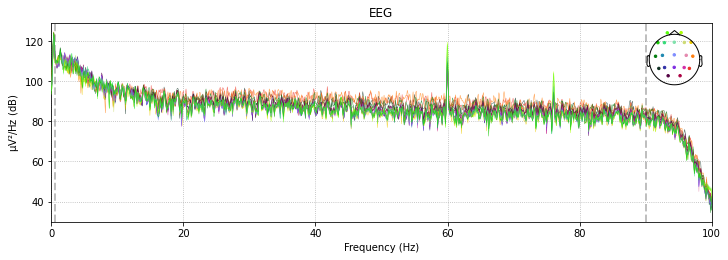

In [103]:
raw1.plot_psd(picks = 'eeg')
plt.show()

/home/clay/.local/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


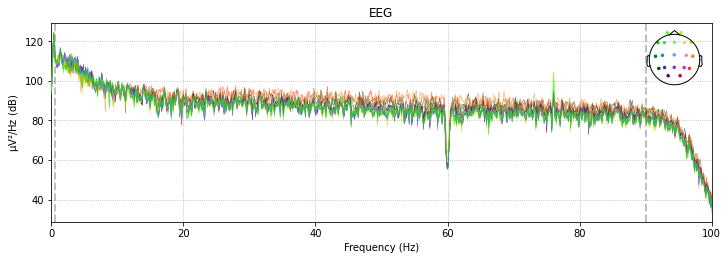

In [104]:
raw2.plot_psd(picks = 'eeg')
plt.show()

In [96]:
#notch_df = full_band_df(2000, activity_df_list, 0.5, 90, notch = True)
#notch_df.to_csv('notch_df.csv', index = None)

In [97]:
notch_df = pd.read_csv('notch_df.csv')

In [98]:
X = notch_df.copy()

scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [99]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (Notch 60 Hz)')
print(classification_report(y_train, training_yhat))
print('Testing (Notch 60 Hz)')
print(classification_report(y_test, testing_yhat))

Training (Notch 60 Hz)
              precision    recall  f1-score   support

         GPD       0.78      0.93      0.85      1794
        GRDA       0.72      0.88      0.79      1819
         LPD       0.74      0.84      0.79      1800
        LRDA       0.81      0.86      0.84      1795
       Other       0.75      0.54      0.62      1808
     Seizure       0.88      0.58      0.70      1784

    accuracy                           0.77     10800
   macro avg       0.78      0.77      0.76     10800
weighted avg       0.78      0.77      0.76     10800

Testing (Notch 60 Hz)
              precision    recall  f1-score   support

         GPD       0.70      0.91      0.79       206
        GRDA       0.55      0.80      0.65       181
         LPD       0.65      0.76      0.70       200
        LRDA       0.79      0.76      0.78       205
       Other       0.55      0.34      0.42       192
     Seizure       0.75      0.41      0.53       216

    accuracy                    

### Notch Filtering Results  
  
The notch filter hurt the testing accuracy by 2%. I'm not sure why. I would have expected to get better results with the frequency band features after handling the common and substantial 60 Hz spikes in the power spectrum. I'll have to do more thinking about this.

I'm going to leave the notch filter on and try global average re-referencing. Before doing that and generating a feature set as was done above, I want to show before and after plots of EEG signals to visualize the effects of re-referencing with the global average.  
  
### Zero Phase vs. Minimum Phase Notch Filtering

In [14]:
raw1 = load_preprocess(grda_df, 25, 0.5, 90, notch = False)
raw2 = load_preprocess(grda_df, 25, 0.5, 90, notch = False)
raw3 = load_preprocess(grda_df, 25, 0.5, 90, notch = False)
raw4 = load_preprocess(grda_df, 250, 0.5, 90, notch = False)
raw5 = load_preprocess(grda_df, 250, 0.5, 90, notch = False)
raw6 = load_preprocess(grda_df, 250, 0.5, 90, notch = False)
raw7 = load_preprocess(grda_df, 500, 0.5, 90, notch = False)
raw8 = load_preprocess(grda_df, 500, 0.5, 90, notch = False)
raw9 = load_preprocess(grda_df, 500, 0.5, 90, notch = False)

In [3]:
help(mne.io.RawArray.notch_filter)

Help on function notch_filter in module mne.io.base:

notch_filter(self, freqs, picks=None, filter_length='auto', notch_widths=None, trans_bandwidth=1.0, n_jobs=None, method='fir', iir_params=None, mt_bandwidth=None, p_value=0.05, phase='zero', fir_window='hamming', fir_design='firwin', pad='reflect_limited', skip_by_annotation=('edge', 'bad_acq_skip'), verbose=None)
    Notch filter a subset of channels.
    
    Parameters
    ----------
    freqs : float | array of float | None
        Specific frequencies to filter out from data, e.g.,
        ``np.arange(60, 241, 60)`` in the US or ``np.arange(50, 251, 50)``
        in Europe. ``None`` can only be used with the mode
        ``'spectrum_fit'``, where an F test is used to find sinusoidal
        components.
    picks : str | array-like | slice | None
        Channels to include. Slices and lists of integers will be interpreted as 
        channel indices. In lists, channel *type* strings (e.g., ``['meg', 
        'eeg']``) will pick

In [4]:
help(mne.io.RawArray.plot_psd)

Help on function plot_psd in module mne.time_frequency.spectrum:

plot_psd(self, fmin=0, fmax=inf, tmin=None, tmax=None, picks=None, proj=False, reject_by_annotation=True, *, method='auto', average=False, dB=True, estimate='auto', xscale='linear', area_mode='std', area_alpha=0.33, color='black', line_alpha=None, spatial_colors=True, sphere=None, exclude='bads', ax=None, show=True, n_jobs=1, verbose=None, **method_kw)
    .. warning:: LEGACY: New code should use .compute_psd().plot().
    
    Plot power or amplitude spectra.
    
    Separate plots are drawn for each channel type. When the data have been
    processed with a bandpass, lowpass or highpass filter, dashed lines (╎)
    indicate the boundaries of the filter. The line noise frequency is also
    indicated with a dashed line (⋮). If ``average=False``, the plot will
    be interactive, and click-dragging on the spectrum will generate a
    scalp topography plot for the chosen frequency range in a new figure.
    
    Paramete

In [10]:
raw = load_preprocess(df, 2500, 0.5, 90, bandpass = False, notch = False, reref = False)

In [12]:
from mne.time_frequency import psd_welch

ImportError: cannot import name 'psd_welch' from 'mne.time_frequency' (/home/clay/.local/lib/python3.8/site-packages/mne/time_frequency/__init__.py)

In [14]:
help(mne.time_frequency.psd)

Help on module mne.time_frequency.psd in mne.time_frequency:

NAME
    mne.time_frequency.psd

DESCRIPTION
    # Authors : Alexandre Gramfort, alexandre.gramfort@inria.fr (2011)
    #           Denis A. Engemann <denis.engemann@gmail.com>
    # License : BSD-3-Clause
    # License: BSD-3-Clause
    # Copyright the MNE-Python contributors.

FUNCTIONS
    psd_array_welch(x, sfreq, fmin=0, fmax=inf, n_fft=256, n_overlap=0, n_per_seg=None, n_jobs=None, average='mean', window='hamming', remove_dc=True, *, output='power', verbose=None)
        Compute power spectral density (PSD) using Welch's method.
        
        Welch's method is described in :footcite:t:`Welch1967`.
        
        Parameters
        ----------
        x : array, shape=(..., n_times)
            The data to compute PSD from.
        sfreq : float
            The sampling frequency.
        fmin : float
            The lower frequency of interest.
        fmax : float
            The upper frequency of interest.
     

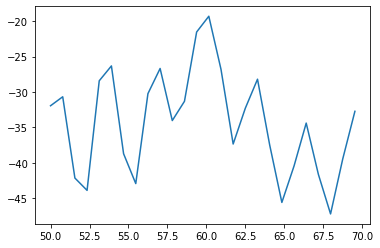

In [17]:
# Apply Spectrum fit 
raw_specfit = raw.copy()

raw_specfit.notch_filter(freqs = None, method = 'spectrum_fit')

# plot the power spectrum for the spectrum fit notch filter 
psd_spec, freqs = mne.time_frequency.psd_array_welch(raw_specfit.get_data(), sfreq = 200, fmin = 50, fmax = 70)    # if you watch plot around 60 Hz
plt.plot(freqs, 10 * np.log10(psd_spec[0]), label = 'Spectrum fit notch')
plt.show()

In [15]:
raw2.notch_filter(60, picks = 'eeg')
raw3.notch_filter(60, phase = 'minimum', picks = 'eeg')
raw5.notch_filter(60, picks = 'eeg')
raw6.notch_filter(60, phase = 'minimum', picks = 'eeg')
raw8.notch_filter(60, picks = 'eeg')
raw9.notch_filter(60, phase = 'minimum', picks = 'eeg')

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,"19 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,EKG
Sampling frequency,200.00 Hz
Highpass,0.50 Hz
Lowpass,90.00 Hz


/home/clay/.local/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/home/clay/.local/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/home/clay/.local/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


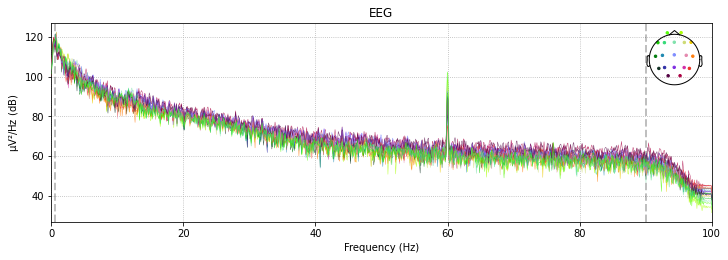

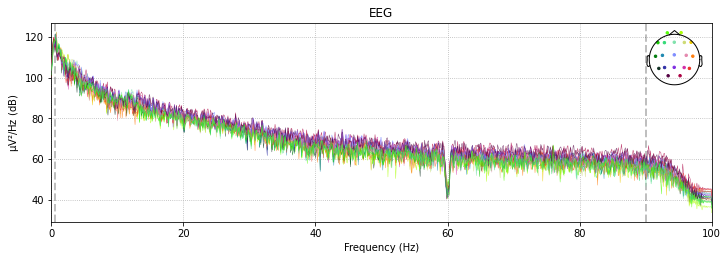

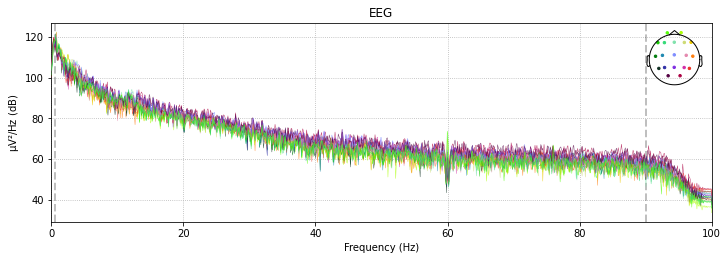

In [16]:
raw1.plot_psd()
raw2.plot_psd()
raw3.plot_psd()
plt.show()

/home/clay/.local/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/home/clay/.local/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/home/clay/.local/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


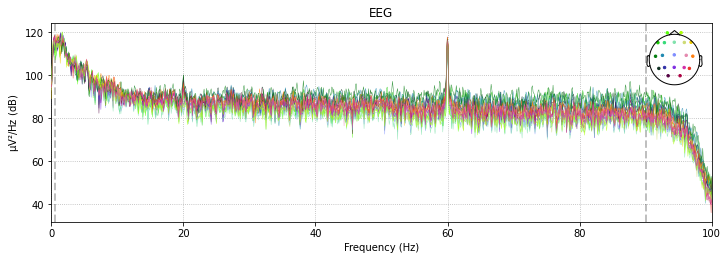

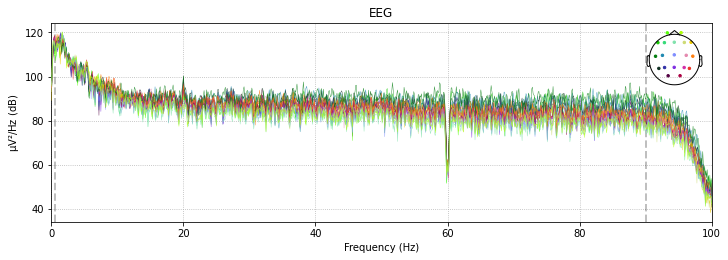

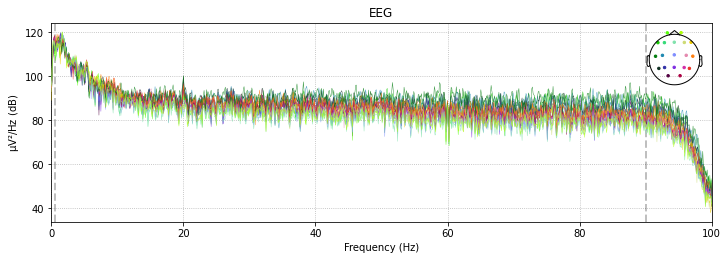

In [17]:
raw4.plot_psd()
raw5.plot_psd()
raw6.plot_psd()
plt.show()

/home/clay/.local/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/home/clay/.local/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/home/clay/.local/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


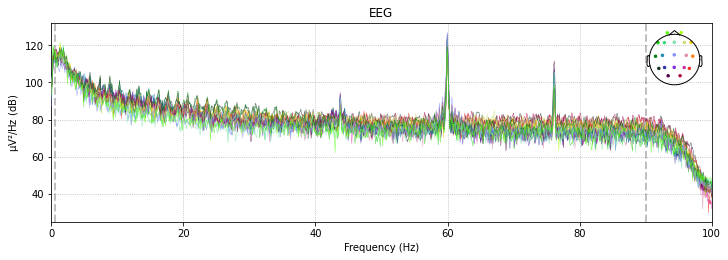

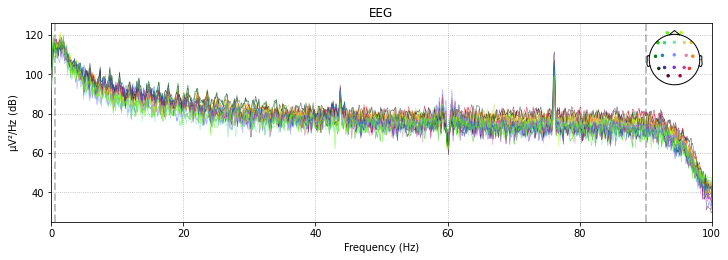

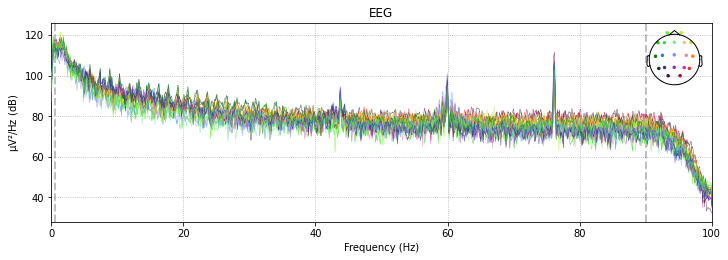

In [18]:
raw7.plot_psd()
raw8.plot_psd()
raw9.plot_psd()
plt.show()

In [8]:
#notch_minimum_df = full_band_df(2000, activity_df_list, 0.5, 90, notch = True)
#notch_minimum_df.to_csv('notch_minimum_df.csv', index = None)

In [7]:
m_notch = pd.read_csv('notch_minimum_df.csv')

In [23]:
X = m_notch.copy()
y_true = get_yvals(2000)

In [24]:
y = y_true['activity'].copy()

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [26]:
from sklearn.metrics import classification_report

In [27]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (Minimum Phase Notch Filter)')
print(classification_report(y_train, training_yhat))
print('Testing (Minimum Phase Notch Filter)')
print(classification_report(y_test, testing_yhat))

Training (Minimum Phase Notch Filter)
              precision    recall  f1-score   support

         GPD       0.79      0.93      0.85      1794
        GRDA       0.74      0.89      0.81      1819
         LPD       0.75      0.84      0.79      1800
        LRDA       0.81      0.87      0.84      1795
       Other       0.74      0.56      0.64      1808
     Seizure       0.88      0.60      0.71      1784

    accuracy                           0.78     10800
   macro avg       0.78      0.78      0.77     10800
weighted avg       0.78      0.78      0.77     10800

Testing (Minimum Phase Notch Filter)
              precision    recall  f1-score   support

         GPD       0.68      0.80      0.74       206
        GRDA       0.57      0.76      0.65       181
         LPD       0.70      0.70      0.70       200
        LRDA       0.73      0.80      0.77       205
       Other       0.49      0.39      0.43       192
     Seizure       0.76      0.49      0.60       216

  

### Minimal Effect  
  
The testing accuracy is still 66%. Given the substantial increase in computational workload, I think it's best to continue forward with zero phase notch filtering. If the computational workloads were similar, I would probably use minimum phase notch filtering because it does diminish the extreme effect the notch filter can have, but it didn't improve results and the feature set took much longer to generate.